Epoch 1, Gen Loss: -9.314379713032395e-05, Disc Loss: -8.817198977340013e-05, Metric Diff: 0.6790914798325003
Epoch 2, Gen Loss: -0.00010500104690436274, Disc Loss: -0.00016705004964023829, Metric Diff: 0.5163431430405081
Epoch 3, Gen Loss: -0.00020802626386284828, Disc Loss: -0.00016132890596054494, Metric Diff: 0.24527234231886275
Epoch 4, Gen Loss: -0.0003990725090261549, Disc Loss: -0.00010770317021524534, Metric Diff: -0.036550689285427235
Epoch 5, Gen Loss: -0.0005391104496084154, Disc Loss: -6.208192644407973e-05, Metric Diff: -0.2695200776511728
Epoch 6, Gen Loss: -0.0004548558499664068, Disc Loss: -7.854041177779436e-05, Metric Diff: -0.4156385099345743
Epoch 7, Gen Loss: -0.00034708602470345795, Disc Loss: -0.00010711474169511348, Metric Diff: -0.4291880165988504
Epoch 8, Gen Loss: -0.00026821595383808017, Disc Loss: -0.00016659070388413966, Metric Diff: -0.3741566574031412
Epoch 9, Gen Loss: -0.000198893976630643, Disc Loss: -0.00018047828052658588, Metric Diff: -0.251887593

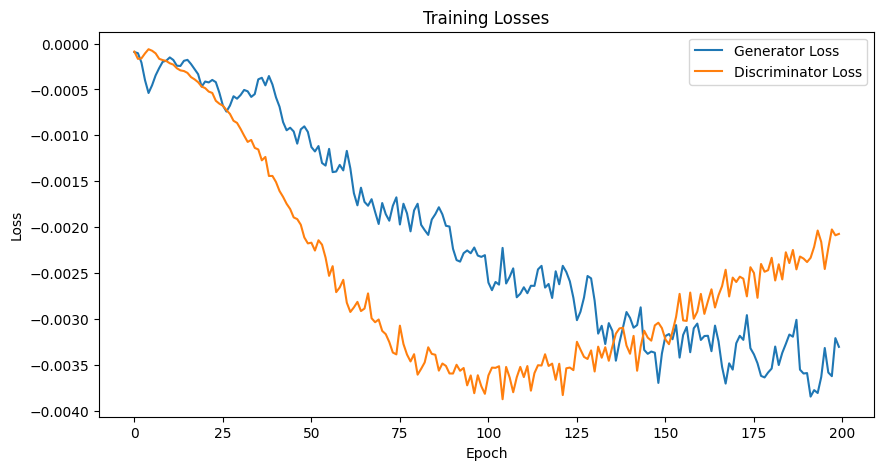

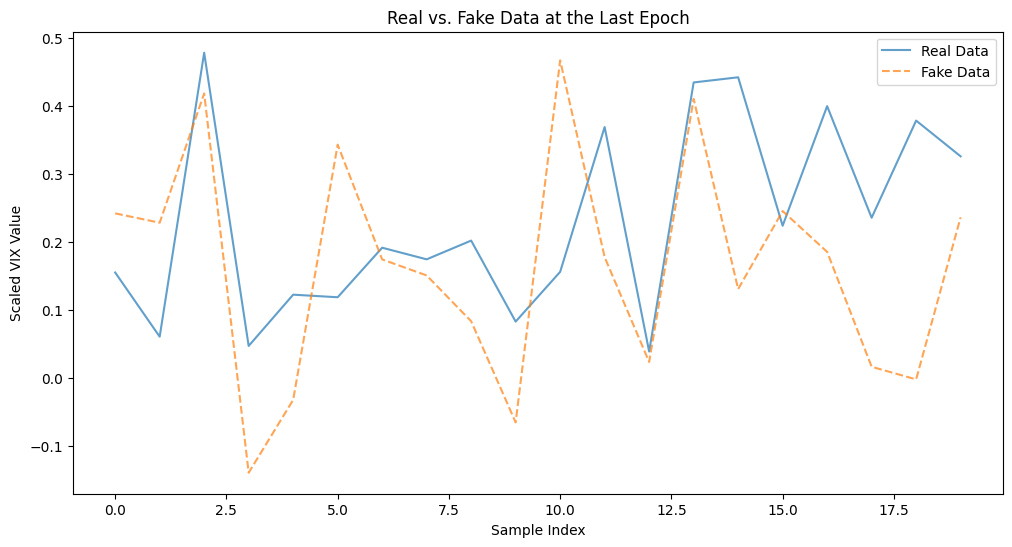

Mean Differences per Epoch: [0.6790914798325003, 0.5163431430405081, 0.24527234231886275, -0.036550689285427235, -0.2695200776511728, -0.4156385099345743, -0.4291880165988504, -0.3741566574031412, -0.25188759321513765, -0.13943320864978426, -0.04266421849074953, 0.020312112027973006, 0.036834862286418774, 0.024667423421710827, -0.001991230791240861, -0.019491169398456715, -0.010468799417644642, -0.011280853098064564, -0.007307622378498219, -0.01752063984218233, -0.022964600270420216, -0.020591098611980607, -0.00649229044261565, 0.02062563245949156, -0.005626518076091935, 0.005204435641139815, 0.0001338685100973347, -0.007619220560222767, -0.018037725036770036, 0.008112754875987838, -0.0031199490481912395, -0.00902493650260558, -0.013503823226123979, 0.005172636563152172, 0.012940403277248214, -0.0028636788779794475, 0.005967643315166304, -0.004022050445705583, 0.000631537491649431, -0.0224736964160501, -0.004872429912716053, 0.004779856855243514, -0.010195482319027088, -0.0018178855830

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load and preprocess the data from our VIX.csv file
data_path = 'VIX.csv'
vix_data = pd.read_csv(data_path)

vix_values = vix_data['VIX'].values.reshape(-1, 1)


#normalizing data

scaler = MinMaxScaler()
vix_values_scaled = scaler.fit_transform(vix_values)
train_dataset = tf.data.Dataset.from_tensor_slices(vix_values_scaled).shuffle(len(vix_values_scaled)).batch(32)

#definining the generator model
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(256, input_shape=(100,), use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Dense(512, use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Dense(1024, use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Dense(1, activation='linear')  #Linear activation
    ])
    return model

#Defining the layers of our critic / disciminator
def make_critic_model():
    model = tf.keras.Sequential([
        layers.Dense(512, input_shape=(1,)),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Dense(256),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Dense(128),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Dense(1)  #No activation function
    ])
    return model

critic = make_critic_model()
generator = make_generator_model()

#Optimizer choice changed to RMSprop from Adam.
critic_optimizer = tf.keras.optimizers.RMSprop(5e-5)
generator_optimizer = tf.keras.optimizers.RMSprop(5e-5)

#Loss functions for the critic and generator
def critic_loss(real_output, fake_output):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

 #Weight clipping enforces the Lipschitz constraint in Wasserstein GANs by limiting the range of the critic's weights, which helps stabilize the training process by preventing gradients from exploding.

# Weight clipping for critic (discriminator)
def clip_weights(weights, c=0.01):
    for weight in weights:
        weight.assign(tf.clip_by_value(weight, -c, c))

#Now training the generator and disciminator in a 1:5 ratio
def train_step(real_data):
    noise = tf.random.normal([32, 100])

    #Training the critic five times per Generator training step
    for _ in range(5):
        with tf.GradientTape() as critic_tape:
            generated_data = generator(noise, training=True)
            real_output = critic(real_data, training=True)
            fake_output = critic(generated_data, training=True)
            c_loss = critic_loss(real_output, fake_output)

        critic_gradients = critic_tape.gradient(c_loss, critic.trainable_variables)
        critic_optimizer.apply_gradients(zip(critic_gradients, critic.trainable_variables))
        clip_weights(critic.trainable_variables)  #using weight clipping

 #Weight clipping enforces the Lipschitz constraint in Wasserstein GANs by limiting the range of the critic's weights, which helps stabilize the training process by preventing gradients from exploding.

    # Train Generator once
    with tf.GradientTape() as gen_tape:
        generated_data = generator(noise, training=True)
        fake_output = critic(generated_data, training=True)
        g_loss = generator_loss(fake_output)

    generator_gradients = gen_tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    return real_data, generated_data, g_loss.numpy(), c_loss.numpy()

# Training function
def train(dataset, epochs):
    gen_losses = []
    disc_losses = []
    metric_diff = []
    final_mean=[]
    for epoch in range(epochs):
        epoch_gen_losses = []
        epoch_disc_losses = []
        real_samples = []
        fake_samples = []

        for real_data in dataset:
            real_data, generated_data, gen_loss, disc_loss = train_step(real_data)
            real_samples.extend(real_data.numpy())
            fake_samples.extend(generated_data.numpy())
            epoch_gen_losses.append(gen_loss)
            epoch_disc_losses.append(disc_loss)

        gen_losses.append(np.mean(epoch_gen_losses))
        disc_losses.append(np.mean(epoch_disc_losses))
        metric_diff.append(np.mean(real_samples) - np.mean(fake_samples))
        final_mean=np.mean(real_samples) - np.mean(fake_samples)

        print(f"Epoch {epoch+1}, Gen Loss: {gen_losses[-1]}, Disc Loss: {disc_losses[-1]}, Metric Diff: {metric_diff[-1]}")

    # Plot training losses for the generator and disciminator
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.title('Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    #Plotting real vs. fake data comparison for a 20 epoch window for better visual inspection.

    display_start_index = 0  #Start index of the sample to display
    display_end_index = 20  #End index of the sample to display

    plt.figure(figsize=(12, 6))
    plt.plot(real_samples[display_start_index:display_end_index], label='Real Data', alpha=0.7)
    plt.plot(fake_samples[display_start_index:display_end_index], label='Fake Data', alpha=0.7, linestyle='--')
    plt.title('Real vs. Fake Data at the Last Epoch')
    plt.xlabel('Sample Index')
    plt.ylabel('Scaled VIX Value')
    plt.legend()
    plt.show()

    return metric_diff

# Train the model
metric_difference = train(train_dataset, epochs=200)
print("Mean Differences per Epoch:", metric_difference)
